<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Applied-Machine-Learning:-Quality-Control-Workflow" data-toc-modified-id="Applied-Machine-Learning:-Quality-Control-Workflow-1">Applied Machine Learning: Quality Control Workflow</a></span><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1.1">Abstract</a></span></li><li><span><a href="#Packages-&amp;-Functions" data-toc-modified-id="Packages-&amp;-Functions-1.2">Packages &amp; Functions</a></span></li><li><span><a href="#Variable-Selection-&amp;-Data-Processing" data-toc-modified-id="Variable-Selection-&amp;-Data-Processing-1.3">Variable Selection &amp; Data Processing</a></span><ul class="toc-item"><li><span><a href="#Training,-Development-and-Testing-Split-(70%,15%,15%)" data-toc-modified-id="Training,-Development-and-Testing-Split-(70%,15%,15%)-1.3.1">Training, Development and Testing Split (70%,15%,15%)</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-1.3.2">Feature Selection</a></span></li></ul></li><li><span><a href="#LinearSVC-Classification-Model" data-toc-modified-id="LinearSVC-Classification-Model-1.4">LinearSVC Classification Model</a></span><ul class="toc-item"><li><span><a href="#LinearSVC-Model-Performance" data-toc-modified-id="LinearSVC-Model-Performance-1.4.1">LinearSVC Model Performance</a></span></li><li><span><a href="#LinearSVC---Macro-average-ROC-curve-&amp;-ROC-area" data-toc-modified-id="LinearSVC---Macro-average-ROC-curve-&amp;-ROC-area-1.4.2">LinearSVC - Macro-average ROC curve &amp; ROC area</a></span></li></ul></li></ul></li></ul></div>



------



# Applied Machine Learning: Quality Control Workflow


**Jose Luis Rodriguez**

**COMP 488 Machine Learning** 

**Loyola University Chicago**

## Abstract

In any business application where data is collected, companies must implement thorough and well-defined quality control work flows. All parties involved should strive for the highest quality and highest performing results in the data collection process. In the process of data collection, it is necessary to establish a quality control protocol (including benchmarks for process and metrics for given features as well as testing) to diminish as much as possible the chance for human error. In this report, a dataset was used containing hand curated survey respondent data including metrics for respondent engagement, network performance, and responses to open-ended questions, among others. The feature that this report aims to automate is the qualification rate feature (whether or not a survey respondent's data is kept in the report).
 
 There were two primary applications where machine learning was proven to be superior to previous manual methods. The data contained some respondent feedback pertaining to their experience/issues that needed to be scored and classified as well, which required the use of a text classifier. The results of the text classifier were merged with a subset of the data, and three different classification algorithms were utilized (KNN, Linear SVC, Random Forest). The preliminary results of this project indicate that it is possible to automate much of the quality control work flow. 

## Packages & Functions

In [1]:
import re
import itertools
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score

In [2]:
def text_processing(messages, max_features = None):
    corpus = []
    for m in messages:
        if pd.notnull(m):
            corpus.append(re.sub(r"\b\d+\b|![:alpha:]|\d|\W|_|\b\w{1,2}\b", " ", m).lower())
        else:
            corpus.append(" ")
    if max_features is not None:
        vectorizer = CountVectorizer(strip_accents = 'ascii', 
                                     stop_words=['english'], 
                                     max_features = max_features)
    else:
        vectorizer = CountVectorizer(strip_accents = 'ascii', stop_words=['english'])
    vcorpus = vectorizer.fit_transform(corpus)
    labels = vectorizer.get_feature_names()
    return vcorpus, labels

def score(x):
    if x>2:
        return 3
    elif x>1:
        return 2
    elif x>0:
        return 1
    else:
        return 0
    
def summary( clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    print('             F1-Score: %.5f'% score)
    print('       Accuracy Score: %.5f'% clf.score(X_test, y_test))
    print('     Model Best Score: %.5f'% clf.best_score_)
    print('Best Parameters Set: %s\n' % clf.best_params_)
    print('-------- Best Estimator -------- \n%s' % clf.best_estimator_)

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def data_split(X,y,splits = [0.3,0.5]):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = splits[0], 
                                                        random_state=1)
    X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, 
                                                    test_size = splits[1], 
                                                    random_state=1)
    return X_train, y_train, X_dev, y_dev, X_test, y_test

## Variable Selection & Data Processing

In [3]:
issues = pd.read_csv('00-data/issues.csv',sep="|",na_filter=False)

In [4]:
issues.head()

,uuid,pooled_responses,pooled_score,score_class
0,018c3299txwr2qqp,Being able to be close enough to read the bott...,1.0,1
1,0207ygcsk0gjmpef,the screen wanted to turn left and right inste...,1.0,1
2,022uf3su0gk79gsk,Nothing They lots of stock and different kind ...,0.0,0
3,038dfe6hjbzkt34k,none yes,0.0,0
4,049f46tkcabh8cfc,NONE IT HAD MANY TYPES THE COLOR OF THE BOTTL...,0.0,0


### Training, Development and Testing Split (70%,15%,15%)

In [5]:
X = responses = issues.pooled_responses
y = issues.score_class.as_matrix()

In [6]:
vcorpus, labels = text_processing(X)
X, y = vcorpus.toarray(), issues.score_class.as_matrix()

In [7]:
X_train, y_train, X_dev, y_dev, X_test, y_test = data_split(X, y, splits = [0.3,0.5])

### Feature Selection

In [8]:
model = OneVsRestClassifier(LinearSVC(C=1))
model.fit(X_train, y_train)
feature_selection = SelectFromModel(model, prefit=True)
X_train = feature_selection.transform(X_train)
X_dev = feature_selection.transform(X_dev)
X_test = feature_selection.transform(X_test)

## LinearSVC Classification Model 

In [ ]:
params = {'estimator__C': ( .5, 1, 5),
          'estimator__class_weight': (None, "balanced")}

In [9]:
clf_svc = OneVsRestClassifier(LinearSVC(loss='hinge'))

In [14]:
gs_svc = GridSearchCV(clf_svc, param_grid= params, n_jobs=-1)
gs_svc.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__C': (0.5, 1, 5), 'estimator__class_weight': (None, 'balanced')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
summary(gs_svc, X_dev, y_dev)

             F1-Score: 0.56798
       Accuracy Score: 0.85453
     Model Best Score: 0.86295
Best Parameters Set: {'estimator__C': 0.5, 'estimator__class_weight': None}

-------- Best Estimator -------- 
OneVsRestClassifier(estimator=LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0),
          n_jobs=1)


### LinearSVC Model Performance

In [16]:
y_pred_cm = gs_svc.predict(X_test)

In [17]:
# Compute confusion matrix
class_names = ['Excellent','Good','Fair','Poor']
cnf_matrix = confusion_matrix(y_test, y_pred_cm)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[ 0.96  0.04  0.    0.  ]
 [ 0.16  0.81  0.02  0.  ]
 [ 0.08  0.8   0.11  0.02]
 [ 0.36  0.42  0.04  0.18]]


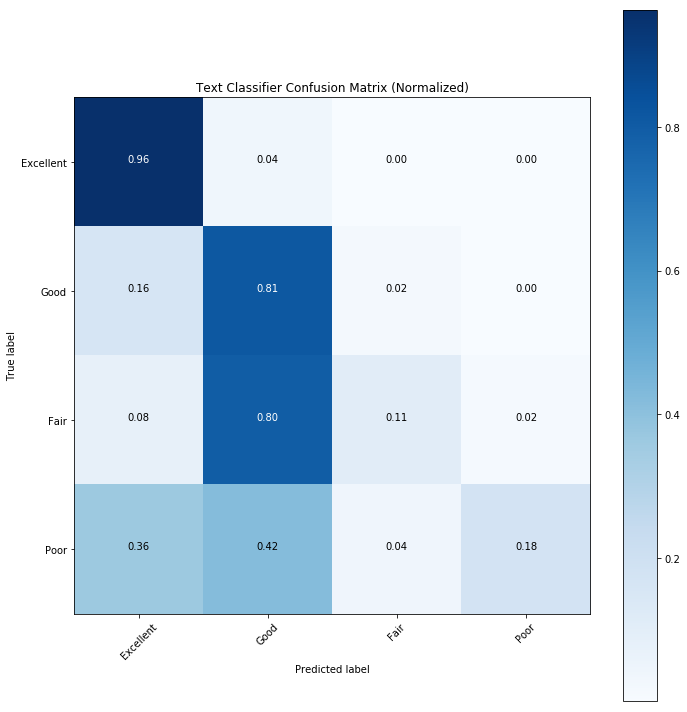

In [18]:
# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, 
                      classes = class_names, 
                      normalize = True,
                      title = 'Text Classifier Confusion Matrix (Normalized)')
plt.show()

Confusion matrix, without normalization
[[3127  114    4    4]
 [ 289 1472   41    7]
 [  25  249   34    5]
 [  37   43    4   18]]


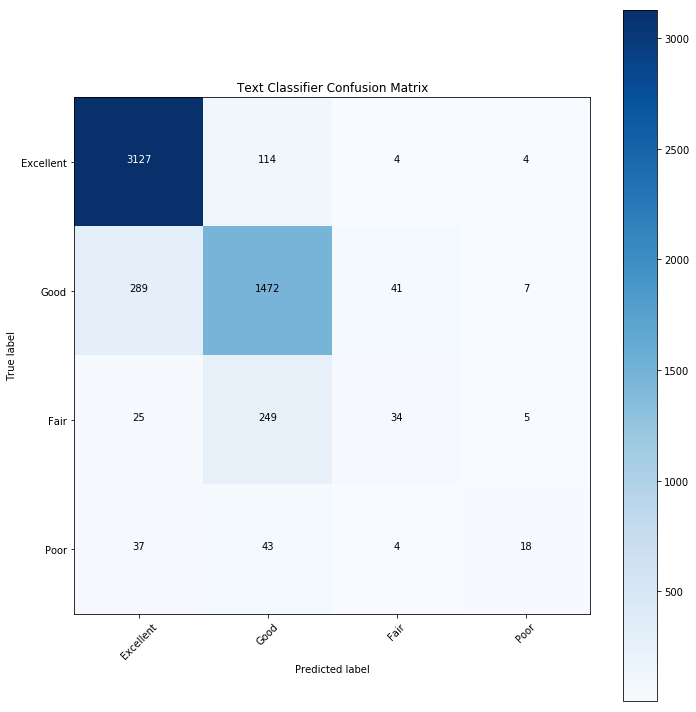

In [19]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names, 
                      title='Text Classifier Confusion Matrix')
plt.show()

### LinearSVC - Macro-average ROC curve & ROC area

In [20]:
y_score = gs_svc.decision_function(X_test)

In [21]:
y = label_binarize(y, classes=[0, 1, 2, 3])
y_test = label_binarize(y_test, classes=[0, 1, 2, 3])

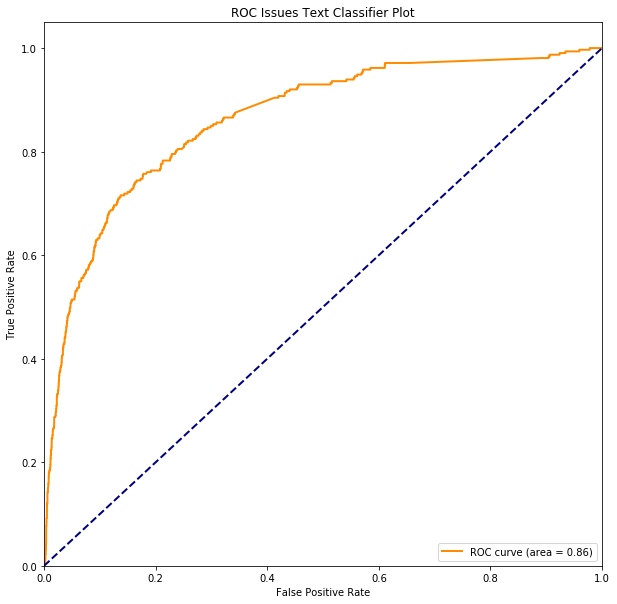

In [22]:
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#### PLOT ROC

plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Issues Text Classifier Plot')
plt.legend(loc="lower right")
plt.show()

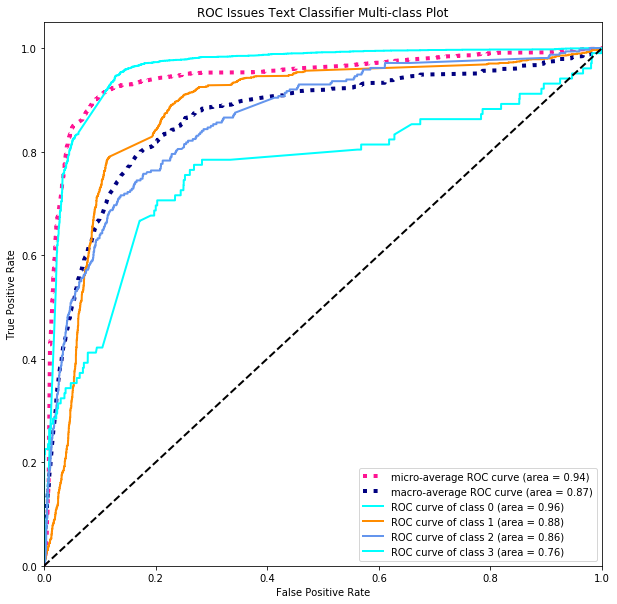

In [23]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Issues Text Classifier Multi-class Plot')
plt.legend(loc="lower right")
plt.show()